In [2]:
import os
import csv
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [48]:
# helper functions

def series_append(series, list, keys):
    for i in range(64):
        series[keys[i]].append(float(list[i]))
    return series

def load_series(filename):
    with open(filename, 'r') as csv_in:
        csv_file = list(csv.reader(csv_in))
        series = {}
        keys = csv_file[0]
        for key in keys: series[key] = []
        for i in range(2, len(csv_file), 2):
            series = series_append(series, csv_file[i], keys)
        return [series, int((len(csv_file) - 2) / 2)]

def make_2D(series):
    l = []
    for key in series:
        if (key[-1] == 'v' or key[-1] == 'z'): continue
        key_list = []
        for e in series[key]:
            key_list.append([e]) # try brackets here
        l.append(key_list)
    return l

def E3(pred, truth):
    num_correct = 0
    for i in range(len(pred)):
        if (abs(pred[i] - truth[i]) <= 3.5):
            num_correct += 1
    return (100.0 * float(num_correct) / float(len(pred)))

def E2(pred, truth):
    num_correct = 0
    for i in range(len(pred)):
        if (abs(pred[i] - truth[i]) <= 2.5):
            num_correct += 1
    return (100.0 * float(num_correct) / float(len(pred)))

def E1(pred, truth):
    num_correct = 0
    for i in range(len(pred)):
        if (abs(pred[i] - truth[i]) <= 1.5):
            num_correct += 1
    return (100.0 * float(num_correct) / float(len(pred)))

def E0(pred, truth):
    num_correct = 0
    for i in range(len(pred)):
        if (abs(pred[i] - truth[i]) <= 0.5):
            num_correct += 1
    return (100.0 * float(num_correct) / float(len(pred)))

torch.Size([93, 32, 7, 1])
torch.Size([93, 5])
torch.Size([371, 32, 7, 1])
torch.Size([371, 5])


[[-0.04510970625758805], [0.15548292136690203], [0.18864269610476436], [0.03013477080729921], [0.02615070618718543], [-0.06870381184544468], [-0.016733536172175174]]
[[1.43357148915248], [1.3875110596464684], [1.3820930323177478], [1.3323338797004969], [1.380012570094935], [1.447214125314459], [1.3975924169719627]]
[[0.16028511925576938], [0.10539241581115354], [0.030515113454916788], [0.020483510064475144], [0.08704708302286145], [-0.04178909919001301], [-0.13672306340039284]]
[[1.410143913334849], [1.3413245131443865], [1.269566923118981], [1.2557151894274403], [1.3029415789401941], [1.3598634687573259], [1.3526648491919826]]
[[-0.17057047096524947], [0.1742577696131439], [0.2600980846614596], [-0.0445378944616656], [-0.1808554290899783], [-0.25808558722859654], [-0.0003875307702551616]]
[[0.9147009694039112], [0.8802537460011054], [0.8675173571074436], [0.8882761794014501], [1.022760088

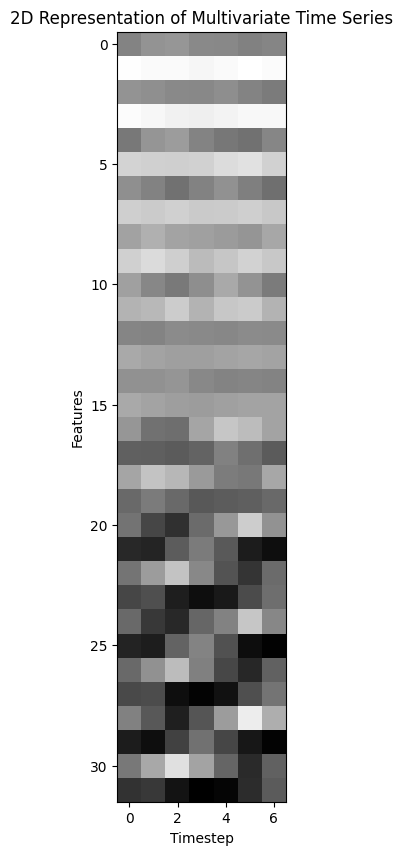

In [55]:
# loading data

X_train_list = []
y_train_list = []

X_test_list = []
y_test_list = []

with open("..\\test_examples.txt") as t:
    test_examples = t.readlines()

for example in test_examples:
    series, num_frames = load_series("..\\time_series\\Time_normalized_stages\\4_final\\" + example[:-1])
    x_example = make_2D(series)
    y_example = [float(example[4]) / 9, float(example[7]) / 9, float(example[10]) / 9, float(example[13]) / 9, float(example[16]) / 9]
    X_test_list.append(x_example)
    y_test_list.append(y_example)

X_test = torch.tensor(X_test_list)
y_test = torch.tensor(y_test_list)
print(X_test.size())
print(y_test.size())

with open("..\\training_examples.txt") as t:
    training_examples = t.readlines()

for example in training_examples:
    series, num_frames = load_series("..\\time_series\\Time_normalized_stages\\4_final\\" + example[:-1])
    x_example = make_2D(series)
    y_example = [float(example[4]) / 9, float(example[7]) / 9, float(example[10]) / 9, float(example[13]) / 9, float(example[16]) / 9]
    X_train_list.append(x_example)
    y_train_list.append(y_example)

X_train = torch.tensor(X_train_list)
y_train = torch.tensor(y_train_list)
print(X_train.size())
print(y_train.size())

print('\n')

for x in X_train_list[0]:
    print(x)

print('\n')

fig = plt.figure(figsize=(10, 10))
plt.set_cmap('gray')
plt.imshow(X_train_list[0])
plt.xlabel('Timestep')
plt.ylabel('Features')
plt.title('2D Representation of Multivariate Time Series')

# NHWC TO NCHW

X_train = X_train.permute(0, 3, 1, 2)
X_test = X_test.permute(0, 3, 1, 2)

In [70]:
# setting up CNN

fc_size1 = 32
fc_size2 = 70
fc_size3 = 50
fc_size4 = 25
output_size = 5
batch_size = 371
learning_rate = 0.001

model = nn.Sequential(
    
                        nn.Conv2d(1, 1, (1,3)),
                        nn.ReLU(),
                        nn.AvgPool2d((1,3)),

                        nn.Conv2d(1, 1, (1,3)),
                        nn.ReLU(),
                        nn.AvgPool2d((1,3)),

                        nn.Linear(fc_size1, fc_size2),
                        nn.ReLU(),

                        nn.Linear(fc_size2, fc_size3),
                        nn.ReLU(),

                        nn.Linear(fc_size3, fc_size4),
                        nn.ReLU(),

                        nn.Linear(fc_size4, output_size),
                        nn.ReLU(),

                        nn.Sigmoid())

loss_function = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [71]:
# model training

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0.01)

num_epochs = 100

print(X_train.size())

losses = []
test_losses = []
for epoch in range(num_epochs):
    pred_y = model(X_train)
    loss = loss_function(pred_y, y_train)
    losses.append(loss.item())

    test_y = model(X_test)
    test_loss = loss_function(test_y, y_test)
    test_losses.append(test_loss.item())

    model.zero_grad()
    loss.backward()

    optimizer.step()

min_loss = min(test_losses)

fig, ax = plt.subplots(1, figsize=(20, 10))

ax.plot(losses, label="Train Error")
ax.plot(test_losses, label="Test Error", c="orange")
ax.set_title("FCNN Training Curves")
ax.set_xticks(np.linspace(0, num_epochs, num=11))

ax.set_ylabel("MSE")
ax.set_xlabel("Epoch")

ax.axvline(100, c='r', label='Training Termination')
ax.legend()

torch.Size([371, 1, 32, 7])


RuntimeError: Calculated padded input size per channel: (32 x 1). Kernel size: (1 x 3). Kernel size can't be greater than actual input size